In [14]:
import pymongo
import pandas as pd
import numpy as np
from pymongo import MongoClient
from datetime import datetime, date, time
from time import sleep
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas(desc="lets do it")
import random
from multiprocessing import Pool
import pycountry
import re
import phonenumbers
import random
from price_parser import Price

from datetime import datetime, date, time, timedelta
import time

# Графики
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")

In [2]:
LIST_EXP = [
    "TN","MA","ZA","AO","DZ","NG","EG","GH","ET","KE","GQ","TD","MG","SC","SL","LY","CG",
    "GA","LR","CM","MW","TZ","TG","GN","SN","UG","CI","SZ","GM","MU","NA","RW","BJ","CV",
    "MZ","SD","SH","ML","MR","BF","BI","GW","NE","RE","SO","ZW","IN","CN","JP","TW","KR",
    "HK","AE","LK","BD","IL","SA","LB","IQ","KW","PK","CY","OM","BH","KZ","QA","JO","MO",
    "IR","AZ","SY","TM","KP","GE","AF","YE","AM","TJ","UZ","IO","KG","MV","IT","DE","ES",
    "PL","IE","TR","GR","BG","SE","LU","AT","NO","DK","CZ","PT","LT","HU","EE","IS","LV",
    "RO","SI","BY","SK","LI","HR","RS","MD","MC","MK","AL","BA","MT","SM","CS","JE","IM",
    "GI","US","MX","CA","BS","PA","TC","BB","TT","KY","VG","CR","GT","AN","DO","VI","PR",
    "BZ","JM","HT","LC","HN","SV","NI","BM","DM","AW","SX","MQ","CU","AG","AI","MF","BQ",
    "GD","KN","AU","NZ","PF","FJ","GU","AS","MH","PG","VU","WS","MP","NC","PW","TO","FM",
    "PE","AR","BR","CO","EC","CL","VE","PY","UY","BO","SR","GY","CW","GF","RU","GB","FR",
    "BE","CH","NL","FI","UA",]

LIST_IMP = ["TH","VN","MY","ID","SG","PH", "KH", "LA", "MM", "BN", "TL"]

import requests

URL = "https://translate.yandex.net/api/v1.5/tr.json/translate"  # Это адрес для обращения к API 
KEY = "trnsl.1.1.20191008T104951Z.e6e91ae7565f127a.f4a125674707c581ca32b312cd61b22ea80cb4b0" # Это API ключ 


KEYS = [
    'trnsl.1.1.20190823T131309Z.9d29e29fc42fd0f8.2e337d4154931ac3a7c9d1d07375213f2e0b1d83',
    'trnsl.1.1.20191014T145232Z.c075f94ea502914c.5644a742741ae07c1f7a1a3c0e104ac53363d94e',
    'trnsl.1.1.20191014T145324Z.dcf6e1face607cef.386d1e7980f726bcd58c0e7f809607fc26b587ad',
    'trnsl.1.1.20191014T145409Z.e6d1a3875a812e5d.647988920060f37016575234aee80adc4f436dcd',
    'trnsl.1.1.20191014T145450Z.abf8a1764dc80c3b.f13c828bb681bf77607dc763562ba120280161fe',
    'trnsl.1.1.20191014T145627Z.ecbd87181db3c697.44cee54580fb3b6a5d60d876e92d182d38cf737e'
]

def yandex_translate(mytext, from_lang, to_lang='en'):
    """Переводит текст с помощью API Яндекса"""
    params = {
        "key": KEYS[random.randint(0, len(KEYS))],     
        "text": mytext,
        "lang": '{0}-{1}'.format(from_lang, to_lang)
    }
    response = requests.get(URL ,params=params)
    
    # Обработка исключений:
    if response.status_code == 401:
        raise TranslaterApiKey('Invalid API key')
    if response.status_code == 402:
        raise TranslaterBlockedKey('Blocked API key')
    if response.status_code == 404:
        raise TranslaterError('Exceeded the daily limit on the amount of translated text')
    if response.status_code == 413:
        raise TranslaterError('Exceeded the maximum text size')
    if response.status_code == 422:
        raise TranslaterError('The text cannot be translated')
    if response.status_code == 501:
        raise TranslaterError('The specified translation direction is not supported')
    if not response.status_code == 200:
        raise TranslaterError('Failed to translate text! {0}'.format(response.reason))

    result = response.json()
    return result['text'][0]


def translate_list(x, from_lang, to_lang='en'):
    transated_list = []
    try:
        for product in x:
            transated_list.append(yandex_translate(product, from_lang, to_lang))
    except:
        print('Ошибка в ф-ции yandex_translate')
        return x
    return transated_list

def yandex_translate_catch_exception(mytext, from_lang, to_lang='en'):
    try:
        s = yandex_translate(mytext, from_lang, to_lang)
    except Exception:
#         Если что-то произошло, мы просто возращаем непереведённый текст
        print('Ошибка перевода')
        return mytext
    else:
#         Если всё хорошо - возвращаем переведённый текст
        return s

def get_db_from_mongo(db_name, collection_name):
    """Принимает название БД и коллекции и возвращает DataFrame"""
    client = MongoClient() # point the client at mongo URI
    client = MongoClient('localhost', 27017) # select database
    db = client[db_name]
    collection = db[collection_name]
    return pd.DataFrame.from_records(collection.find())

COLS = [
    'import/export', 'place_from_picture', 'source', 'country', 'name', 'phone', 'email', 'website', 'product',
    'all_products', 'description', 'bigdata_comments', 'department', r'call_attempt(0\1)', r'exists_or_not(0\1)', r'speak_english(0\1)',
    r'relevance(0\1)', 'volume_of_goods', 'preliminary_price', r'Import/Export(0\1)', 'LC', 'trader_comments', 'current_contacts']


def create_empty_standart_df():
    return pd.DataFrame(columns=COLS)


def parse_telephone_number(number):
    x = phonenumbers.parse(number)
    return phonenumbers.format_number(x, phonenumbers.PhoneNumberFormat.INTERNATIONAL)

def parse_list_of_telephone_numbers(numbers):
    output = []
    for number in numbers:
        try:
            output.append(parse_telephone_number(number))
        except:
            print("""Can't parse number:""", number)
    return output

def group_by_hs_code_and_delete_dublicates(data):
    """Удаляет дубликаты компаний с одинаковым hs_code
        !!! ТАКЖЕ удаляет пропущенные значения !!!"""
    shape1 = data.shape[0]

    data.drop_duplicates(["hs_code", "name"], inplace=True)

    shape2 = data.shape[0]
    print(f'Мы удалили {shape1-shape2} дубликатов')
    
    
def save_db(data, sourse, country, hs_code, folder='', isExcel=True):
    """Сохраняет данные по hs_code в нужно формате
    @data - сами данные
    @sourse - название источника, откуда были выкачены данные
    @folder - название папки, в которое будет происходит сохранение (например: 'data/...')
    @isExcel - формат. True - в .xlsx, False - в .csv
    """
    if isExcel:
        data.to_excel(folder+sourse+'_'+country+str(datetime.now().strftime("_%y-%m-%d"))+'_'+str(hs_code)+'.xlsx', index = False)
    else:
        data.to_csv(folder+sourse+'_'+country+str(datetime.now().strftime("_%y-%m-%d"))+'_'+str(hs_code)+'.csv', index = False)
    
    
def parse_date_into_right_format(df, column_name='last_update'):
    """Меняет формат из такого: 11 Oct 2019, в такой: 2019-10-11"""
    df[column_name] = df[column_name].apply(lambda x: datetime.strptime(x, '%d %b %Y').strftime('%Y-%m-%d'))
    
    
    
import pycountry
import jellyfish

BAD_COUNTRIES = []
def parse_country_name_to_ISO(country_list, df_all_county):
    """@country_list - str or list of countries
       @df_all_county - pd.DataFrame of all countries
       
       If it is impossible parse country by lib pycountry, algorithm find the most consonant country by
       Jaro distance in jellyfish library.
       
       !!!WARNING!!!
       After using this function you have to clean BAD_COUNTRIES like this: BAD_COUNTRIES.clear()
    """
    new_country_list = []
    
    if country_list:
        if isinstance(country_list, str):
            country_list = country_list.split(',')
            
        for name in country_list:
            try:
                new_country_list.append(pycountry.countries.search_fuzzy(name.strip())[0].alpha_2)
            except LookupError:
                tmp = df_all_county[df_all_county['value'].apply(lambda x: jellyfish.jaro_distance(x, name) > 0.75)]
                if tmp.shape[0] > 0:    
                    new_name = tmp.values[0][1]
                    if name not in BAD_COUNTRIES:
                        print(f"I can't translate {name}. Sorry... :(. I replace {name} to {new_name}")
                        BAD_COUNTRIES.append(name)
                    new_country_list.append(tmp.values[0][0])
        return new_country_list

# Считываем данные

In [5]:
df = get_db_from_mongo('companies', 'ec21_1')
print(df.shape)
df.drop('_id', axis=1, inplace=True)
df.head()

(1424, 10)


,city,company,contact,country,date,description,href,price,searching_href
0,City ELECTRON JOHANNESBURG SOUTH,Company Name SAPROCO INTERNATIONAL,Contact TAYLOR MADISON(Mr.),Country/Region South Africa,2019-10-15,Carbon Black N330 N220 N550 N660 Test Data: T...,https://www.ec21.com/product-details/Carbon-Bl...,US$ \ 350 ~ 500 / Metric Ton,carbon-blacks
1,City Shijiazhuang,Company Name Hebei Pengtai Import and Export C...,Contact JHON(Mr.),Country/Region China,2019-10-15,Name: Carbon black CAS No: 1333-86-4 EINECS N...,https://www.ec21.com/product-details/Carbon-Bl...,None,carbon-blacks
2,City Moscow,Company Name Craig & Rupert Denis Limited,Contact Craig Malone(Mr.),Country/Region Russia,2019-10-15,CARBON BLACK REINFORCING CARBON BLACK GOST 78...,https://www.ec21.com/product-details/Carbon-Bl...,US$ 320 / Metric Ton,carbon-blacks
3,City Bang Lamung,Company Name Sarnrax-Trading Company Ltd จุด...,Contact Dang Sonthi(Mr.),Country/Region Thailand,2019-10-15,"Carbon black used in paint,ink,leather,master...",https://www.ec21.com/product-details/Carbon-Bl...,None,carbon-blacks
4,City Weifang,"Company Name Zonpak New Materials Co.,Ltd.",Contact Lein Chang(Mr.),Country/Region China,2019-10-15,ZonpakTM low melt EVA valve bag is a special ...,https://www.ec21.com/product-details/EVA-Valve...,US$ 0.38 ~ 0.4 / Piece,carbon-blacks


### Удаляем данные, где нет цен:

In [6]:
shape1 = df.shape[0]
df.dropna(subset=['price'], inplace=True)
print(f'deleted {shape1 - df.shape[0]}')

deleted 764


### Предобработка данных:

Удаляем весь лишний мусор

In [7]:
COLUMNS = {
    'city' : 'City ',
    'company' : 'Company Name ',
    'contact' : 'Contact ',
    'country' : 'Country/Region '
}
    
    
def drop_and_clean(df, column):
    shape1 = df.shape[0]
    df.dropna(subset=[column], inplace=True)
    df[column] = df[column].apply(lambda x: x.replace(COLUMNS[column], ''))
    print(f'{column}: deleted {shape1 - df.shape[0]} records')

In [8]:
for column in ['city', 'company', 'contact', 'country']:
    drop_and_clean(df, column)

city: deleted 0 records
company: deleted 0 records
contact: deleted 0 records
country: deleted 0 records


### Страну в ISO

In [9]:
df_all_county = pd.read_csv('country.csv')
df.country = df.country.progress_apply(lambda x: parse_country_name_to_ISO(x, df_all_county))
BAD_COUNTRIES.clear()
df['country'] = df['country'].apply(lambda x: x[0])

I can't translate Indon esia. Sorry... :(. I replace Indon esia to Indonesia
I can't translate Hon g Kon g. Sorry... :(. I replace Hon g Kon g to Hong Kong SAR China
I can't translate Eston ia. Sorry... :(. I replace Eston ia to Estonia



### Eсли встречаются слова active или recycled - это нам скорее всего не подходит

In [10]:
df = df[~df.description.apply(lambda x: x.lower().find('recycled') > -1 and x.lower().find('active') > -1)]

### Удаляем компании, в описании у которых не написано про Carbon:

In [11]:
print(f'Было: {df.shape}')
df = df[df.description.apply(lambda x: x.lower().find('carbon') >= 0)]
df = df[df.href.apply(lambda x: x.lower().find('carbon') >= 0)]
print(f'Стало: {df.shape}')

Было: (658, 9)
Стало: (101, 9)


### Посмотрим на количество стран:

In [104]:
from bokeh.io import output_file, output_notebook, show
from bokeh.models import ColumnDataSource
from bokeh.palettes import Spectral11, Spectral10
from bokeh.plotting import figure
from collections import Counter 

def draw_interactive_countplot(df, title=''):
#     output_file(title+".html") # to save plot

    fruits = list(Counter(df.country))
    counts = list(Counter(df.country).values())

    color = Spectral11 if len(counts) == 11 else Spectral10
    source = ColumnDataSource(data=dict(fruits=fruits, counts=counts, color=color))

    TOOLTIPS = [
        ("count", "@counts"),
        ("country", "@fruits"),
    ]

    output_notebook()
    p = figure(x_range=fruits, plot_width=900, title=title, tooltips=TOOLTIPS)

    p.vbar(x='fruits', top='counts', width=0.9, color='color', legend="fruits", source=source)

    p.xgrid.grid_line_color = None
    p.legend.orientation = "horizontal"
    show(p)

In [105]:
draw_interactive_countplot(df, 'The count of countries in the database')
draw_interactive_countplot(df[df.country != 'CN'], 'The count of countries in the database without China')

Loading BokehJS ...

Loading BokehJS ...

### Работаем с ценой и минимальным заказом

In [144]:
df['normal_price'] = df.price.str.split('/').apply(lambda x: x[0])
df['min_order'] = df.price.str.split('/').apply(lambda x: x[1])

df['currency'] = df.normal_price.str.split().apply(lambda x: x[0]) # создание отдельной колонки валюты

for currency in df['currency'].unique(): # удаляем валюты
    df['normal_price'] = df['normal_price'].apply(lambda x: x.replace(currency, ''))
    
df['normal_price'] = df['normal_price'].str.split('\\').apply(lambda x: x[-1].strip().split(' ~ ')) # разбиваем диапазон цен

df['normal_price'] = df['normal_price'].apply(lambda x: np.mean([float(i) for i in x])) # находим среднее

#### Приводим всё к USD:

In [181]:
df['price in USD'] = (df['normal_price'].apply(lambda x: str(x)) + ' ' + df['currency']).apply(lambda x: Price.fromstring(x))

def change_to_USD(price):
    """Поддержка только € и CNY
       Курс валют на 16.10.19"""
    
    if price.currency == '€':
        return price.amount_float * 1.1
    elif price.currency == 'CNY':
        return price.amount_float * 0.14
    return price.amount_float

df['price in USD'] = df['price in USD'].apply(lambda x: change_to_USD(x))

#### Работаем с тоннами и кг:

In [228]:
# Остальные данные совсем нерелевантные
df = df[df.min_order.apply(lambda x: x.lower().find('ton') > -1 or \
                       x.lower().find('kg') > -1 or \
                       x.lower().find('metric') > -1 or \
                       x.lower().find('kilo') > -1 or \
                       x.strip().lower() == 't' or \
                       x.strip().lower() == 'mt')]

df = df[~df.min_order.apply(lambda x: x.strip().lower().find('carton') > -1)] # удаляем 'carton', если есть

import spacy
nlp = spacy.load('en', disable=['parser', 'ner'])
df['min_order'] = df.min_order.apply(lambda x: str(nlp(x.strip().lower())[-1])) # леметизируем текст


def parse_kilo_and(x):
    if x.find('kilo') > -1 or x.find('kg') > -1:
        return 'kg'
    else:
        return 'ton'
    
df['min_order'] = df.min_order.apply(lambda x: parse_kilo_and(x))

In [254]:
df['USD_per_ton'] = df['price in USD'] * df.min_order.apply(lambda x: 1 if x == 'ton' else 1000)

## Тут начинается ручная обработка

In [273]:
def praw_boxplot(df, y='USD_per_ton', x='country'):
    plt.figure(figsize=(9,12))
    ax = sns.boxplot(y='USD_per_ton', x='country', data=df)
    ax = sns.swarmplot(y="USD_per_ton", x="country", data=df, color=".25")
    plt.xlabel('Country ISO', fontsize=14)
    plt.ylabel('USD per ton', fontsize=14)
    # ax.set_xticklabels(['South Africa', 'China', 'Viet Nam', 'Thailand'])
    plt.title('Arbitrage prices by carbon black from different counries', fontsize=16)
    plt.show()
    # plt.savefig('foo.png')

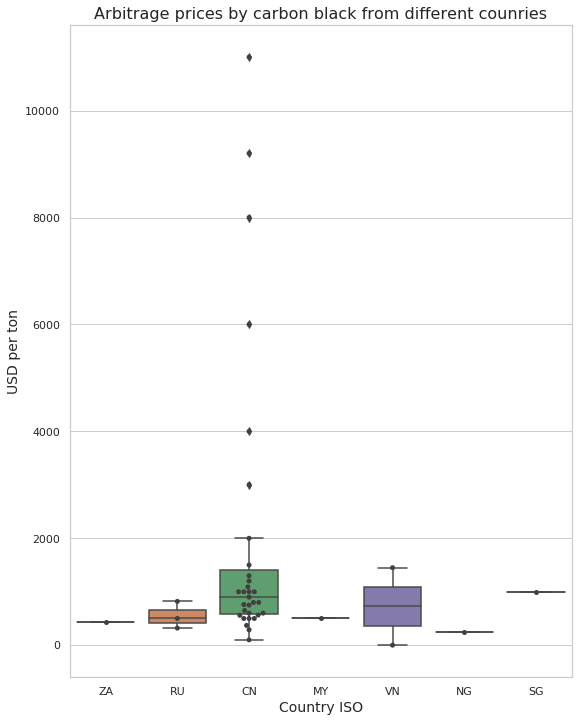

In [274]:
praw_boxplot(df)

In [290]:
df = df[~((df.country == 'CN') & (df.USD_per_ton > 2000))] # удаляем выбросы

In [295]:
df[((df.country == 'VN') & (df.USD_per_ton < 10))].href.values # посмотрим, выброс ли это

array(['https://www.ec21.com/product-details/Activated-Carbon--10753638.html'],
      dtype=object)

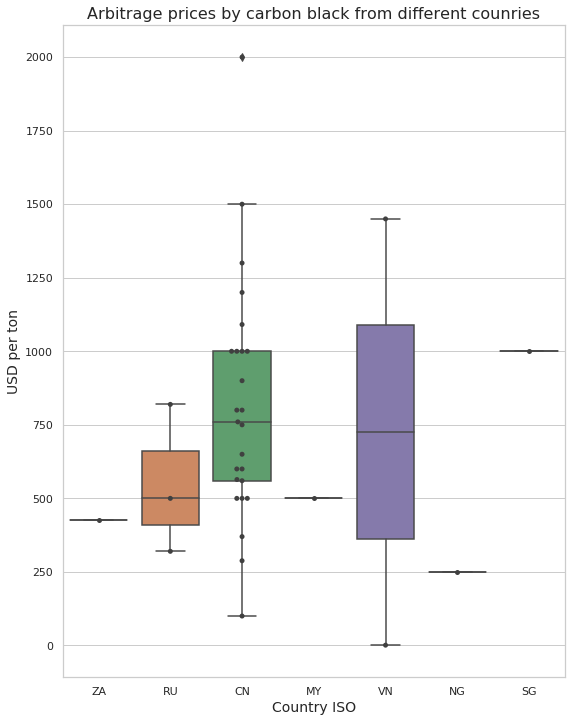

In [292]:
praw_boxplot(df)

In [321]:
df.groupby(by='country').agg({'normal_price':['mean', 'median', 'min', 'max', 'count']}).reset_index()

country normal_price                              
                  mean  median     min     max count
0      CN   773.360000   750.0     1.0  2000.0    25
1      MY   500.000000   500.0   500.0   500.0     1
2      NG   250.000000   250.0   250.0   250.0     1
3      RU   521.666667   500.0   320.0   745.0     3
4      SG  1000.000000  1000.0  1000.0  1000.0     1
5      VN   725.500000   725.5     1.0  1450.0     2
6      ZA   425.000000   425.0   425.0   425.0     1

In [331]:
df_to_save = df[['city', 'company', 'contact', 'country', 'description', 'searching_href', 'min_order', 'USD_per_ton', 'href', 'date']].rename({'href':'source'}, axis=1)

In [333]:
df_to_save.to_excel('price_280300_2019-10-16.xlsx', index = False)